## Objective

### Abstract: Predict whether income exceeds $50K/yr based on census data. Also known as "Census Income" dataset.

In [1]:
# Source
# https://archive.ics.uci.edu/ml/datasets/Adult

## Setup

In [2]:
# Import required libraries

import tensorflow as tf
import numpy as np
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import backend as K
from sklearn.metrics import classification_report
tf.keras.backend.clear_session()
print("Tensorflow version: ", tf.__version__)

Tensorflow version:  2.6.0


## Data Preparation

In [3]:
# Read the train data

train_df = pd.read_csv('adult.data', names=['age','workclass','fnlwgt','education','education_num','marital_status','occupation','relationship','race','sex','capital_gain',
                                            'capital_loss','hours_per_week','native_country','income_level'], sep=', ', engine='python')
print(train_df.shape)
train_df.head()

(32561, 15)


,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income_level
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [4]:
# Train data info
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             32561 non-null  int64 
 1   workclass       32561 non-null  object
 2   fnlwgt          32561 non-null  int64 
 3   education       32561 non-null  object
 4   education_num   32561 non-null  int64 
 5   marital_status  32561 non-null  object
 6   occupation      32561 non-null  object
 7   relationship    32561 non-null  object
 8   race            32561 non-null  object
 9   sex             32561 non-null  object
 10  capital_gain    32561 non-null  int64 
 11  capital_loss    32561 non-null  int64 
 12  hours_per_week  32561 non-null  int64 
 13  native_country  32561 non-null  object
 14  income_level    32561 non-null  object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB


In [5]:
# There are some values in the categorical variables where the values are missing indicated by "?",
# those values are replaced with the value "unknown" in the entrie dataset

train_df.replace({"?" : "unknown"}, inplace=True)

In [6]:
# Replace the target variable values as 0 and 1

train_df['income_level'].replace({"<=50K" : 0, ">50K" : 1}, inplace=True)
train_df['income_level'] = train_df['income_level'].astype(np.int64)
train_df.head()

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income_level
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,0
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,0
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,0
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,0
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,0


In [7]:
# Split the dataframe into train and validation sets

val_df = train_df.sample(frac=0.1, random_state=4339)
train_df = train_df.drop(val_df.index)
print("%d train samples and %d validation samples"
      % (len(train_df), len(val_df)))

29305 train samples and 3256 validation samples


In [8]:
# Convert pandas dataframe to tensorflow dataset

def df_to_ds(df):
    df = df.copy()
    labels = df.pop("income_level")
    ds = tf.data.Dataset.from_tensor_slices((dict(df), labels))
    ds = ds.shuffle(buffer_size=len(df))
    return ds
    
train_ds = df_to_ds(train_df)
val_ds = df_to_ds(val_df)

2021-11-30 21:58:35.403382: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [9]:
# Check a sample record

for x, y in train_ds.take(1):
    print("Input:", x)
    print("Target:", y)

Input: {'age': <tf.Tensor: shape=(), dtype=int64, numpy=35>, 'workclass': <tf.Tensor: shape=(), dtype=string, numpy=b'Self-emp-inc'>, 'fnlwgt': <tf.Tensor: shape=(), dtype=int64, numpy=175769>, 'education': <tf.Tensor: shape=(), dtype=string, numpy=b'HS-grad'>, 'education_num': <tf.Tensor: shape=(), dtype=int64, numpy=9>, 'marital_status': <tf.Tensor: shape=(), dtype=string, numpy=b'Married-civ-spouse'>, 'occupation': <tf.Tensor: shape=(), dtype=string, numpy=b'Sales'>, 'relationship': <tf.Tensor: shape=(), dtype=string, numpy=b'Husband'>, 'race': <tf.Tensor: shape=(), dtype=string, numpy=b'White'>, 'sex': <tf.Tensor: shape=(), dtype=string, numpy=b'Male'>, 'capital_gain': <tf.Tensor: shape=(), dtype=int64, numpy=0>, 'capital_loss': <tf.Tensor: shape=(), dtype=int64, numpy=0>, 'hours_per_week': <tf.Tensor: shape=(), dtype=int64, numpy=65>, 'native_country': <tf.Tensor: shape=(), dtype=string, numpy=b'United-States'>}
Target: tf.Tensor(1, shape=(), dtype=int64)


In [10]:
train_ds = train_ds.batch(32)
val_ds = val_ds.batch(32)

## Feature preprocessing with Keras layers

In [11]:
from tensorflow.keras.layers import IntegerLookup
from tensorflow.keras.layers import Normalization
from tensorflow.keras.layers import StringLookup

def encode_numerical_feature(feature, name, dataset):
    normalizer = Normalization()
    feature_ds = dataset.map(lambda x, y: x[name])
    feature_ds = feature_ds.map(lambda x: tf.expand_dims(x, -1))
    normalizer.adapt(feature_ds)
    encoded_feature = normalizer(feature)
    return encoded_feature

def encode_categorical_feature(feature, name, dataset, is_string):
    lookup_class = StringLookup if is_string else IntegerLookup
    lookup = lookup_class(output_mode="binary")
    feature_ds = dataset.map(lambda x, y: x[name])
    feature_ds = feature_ds.map(lambda x: tf.expand_dims(x, -1))
    lookup.adapt(feature_ds)
    encoded_feature = lookup(feature)
    return encoded_feature

## Build a model

In [12]:
%%time

# Categorical feature encoded as integers
education_num = keras.Input(shape=(1,), name="education_num", dtype="int64")

# Categorical features encoded as string
workclass = keras.Input(shape=(1,), name="workclass", dtype="string")
education = keras.Input(shape=(1,), name="education", dtype="string")
marital_status = keras.Input(shape=(1,), name="marital_status", dtype="string")
occupation = keras.Input(shape=(1,), name="occupation", dtype="string")
relationship = keras.Input(shape=(1,), name="relationship", dtype="string")
race = keras.Input(shape=(1,), name="race", dtype="string")
sex = keras.Input(shape=(1,), name="sex", dtype="string")
native_country = keras.Input(shape=(1,), name="native_country", dtype="string")

# Numerical features
age = keras.Input(shape=(1,), name="age")
fnlwgt = keras.Input(shape=(1,), name="fnlwgt")
capital_gain = keras.Input(shape=(1,), name="capital_gain")
capital_loss = keras.Input(shape=(1,), name="capital_loss")
hours_per_week = keras.Input(shape=(1,), name="hours_per_week")

all_inputs = [education_num, workclass, education, marital_status, occupation,
              relationship, race, sex, native_country, age, fnlwgt, capital_gain,
              capital_loss, hours_per_week]

# Integer categorical features
education_num_encoded = encode_categorical_feature(education_num, "education_num", train_ds, False)

# String categorical features
workclass_encoded = encode_categorical_feature(workclass, "workclass", train_ds, True)
education_encoded = encode_categorical_feature(education, "education", train_ds, True)
marital_status_encoded = encode_categorical_feature(marital_status, "marital_status", train_ds, True)
occupation_encoded = encode_categorical_feature(occupation, "occupation", train_ds, True)
relationship_encoded = encode_categorical_feature(relationship, "relationship", train_ds, True)
race_encoded = encode_categorical_feature(race, "race", train_ds, True)
sex_encoded = encode_categorical_feature(sex, "sex", train_ds, True)
native_country_encoded = encode_categorical_feature(native_country, "native_country", train_ds, True)

# Numerical features
age_encoded = encode_numerical_feature(age, "age", train_ds)
fnlwgt_encoded = encode_numerical_feature(fnlwgt, "fnlwgt", train_ds)
capital_gain_encoded = encode_numerical_feature(capital_gain, "capital_gain", train_ds)
capital_loss_encoded = encode_numerical_feature(capital_loss, "capital_loss", train_ds)
hours_per_week_encoded = encode_numerical_feature(hours_per_week, "hours_per_week", train_ds)

all_features = layers.concatenate([education_num_encoded, workclass_encoded, education_encoded,
                                   marital_status_encoded, occupation_encoded,relationship_encoded,
                                   race_encoded, sex_encoded, native_country_encoded, age_encoded,
                                   fnlwgt_encoded, capital_gain_encoded, capital_loss_encoded,
                                   hours_per_week_encoded])

x = layers.Dense(32, activation='relu')(all_features)
x = layers.Dropout(0.5)(x)
output = layers.Dense(1, activation='sigmoid')(x)
model = keras.Model(all_inputs, output)
model.compile("adam", "binary_crossentropy", metrics=["accuracy"])

2021-11-30 21:58:35.662550: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


CPU times: user 10 s, sys: 958 ms, total: 11 s
Wall time: 6.5 s


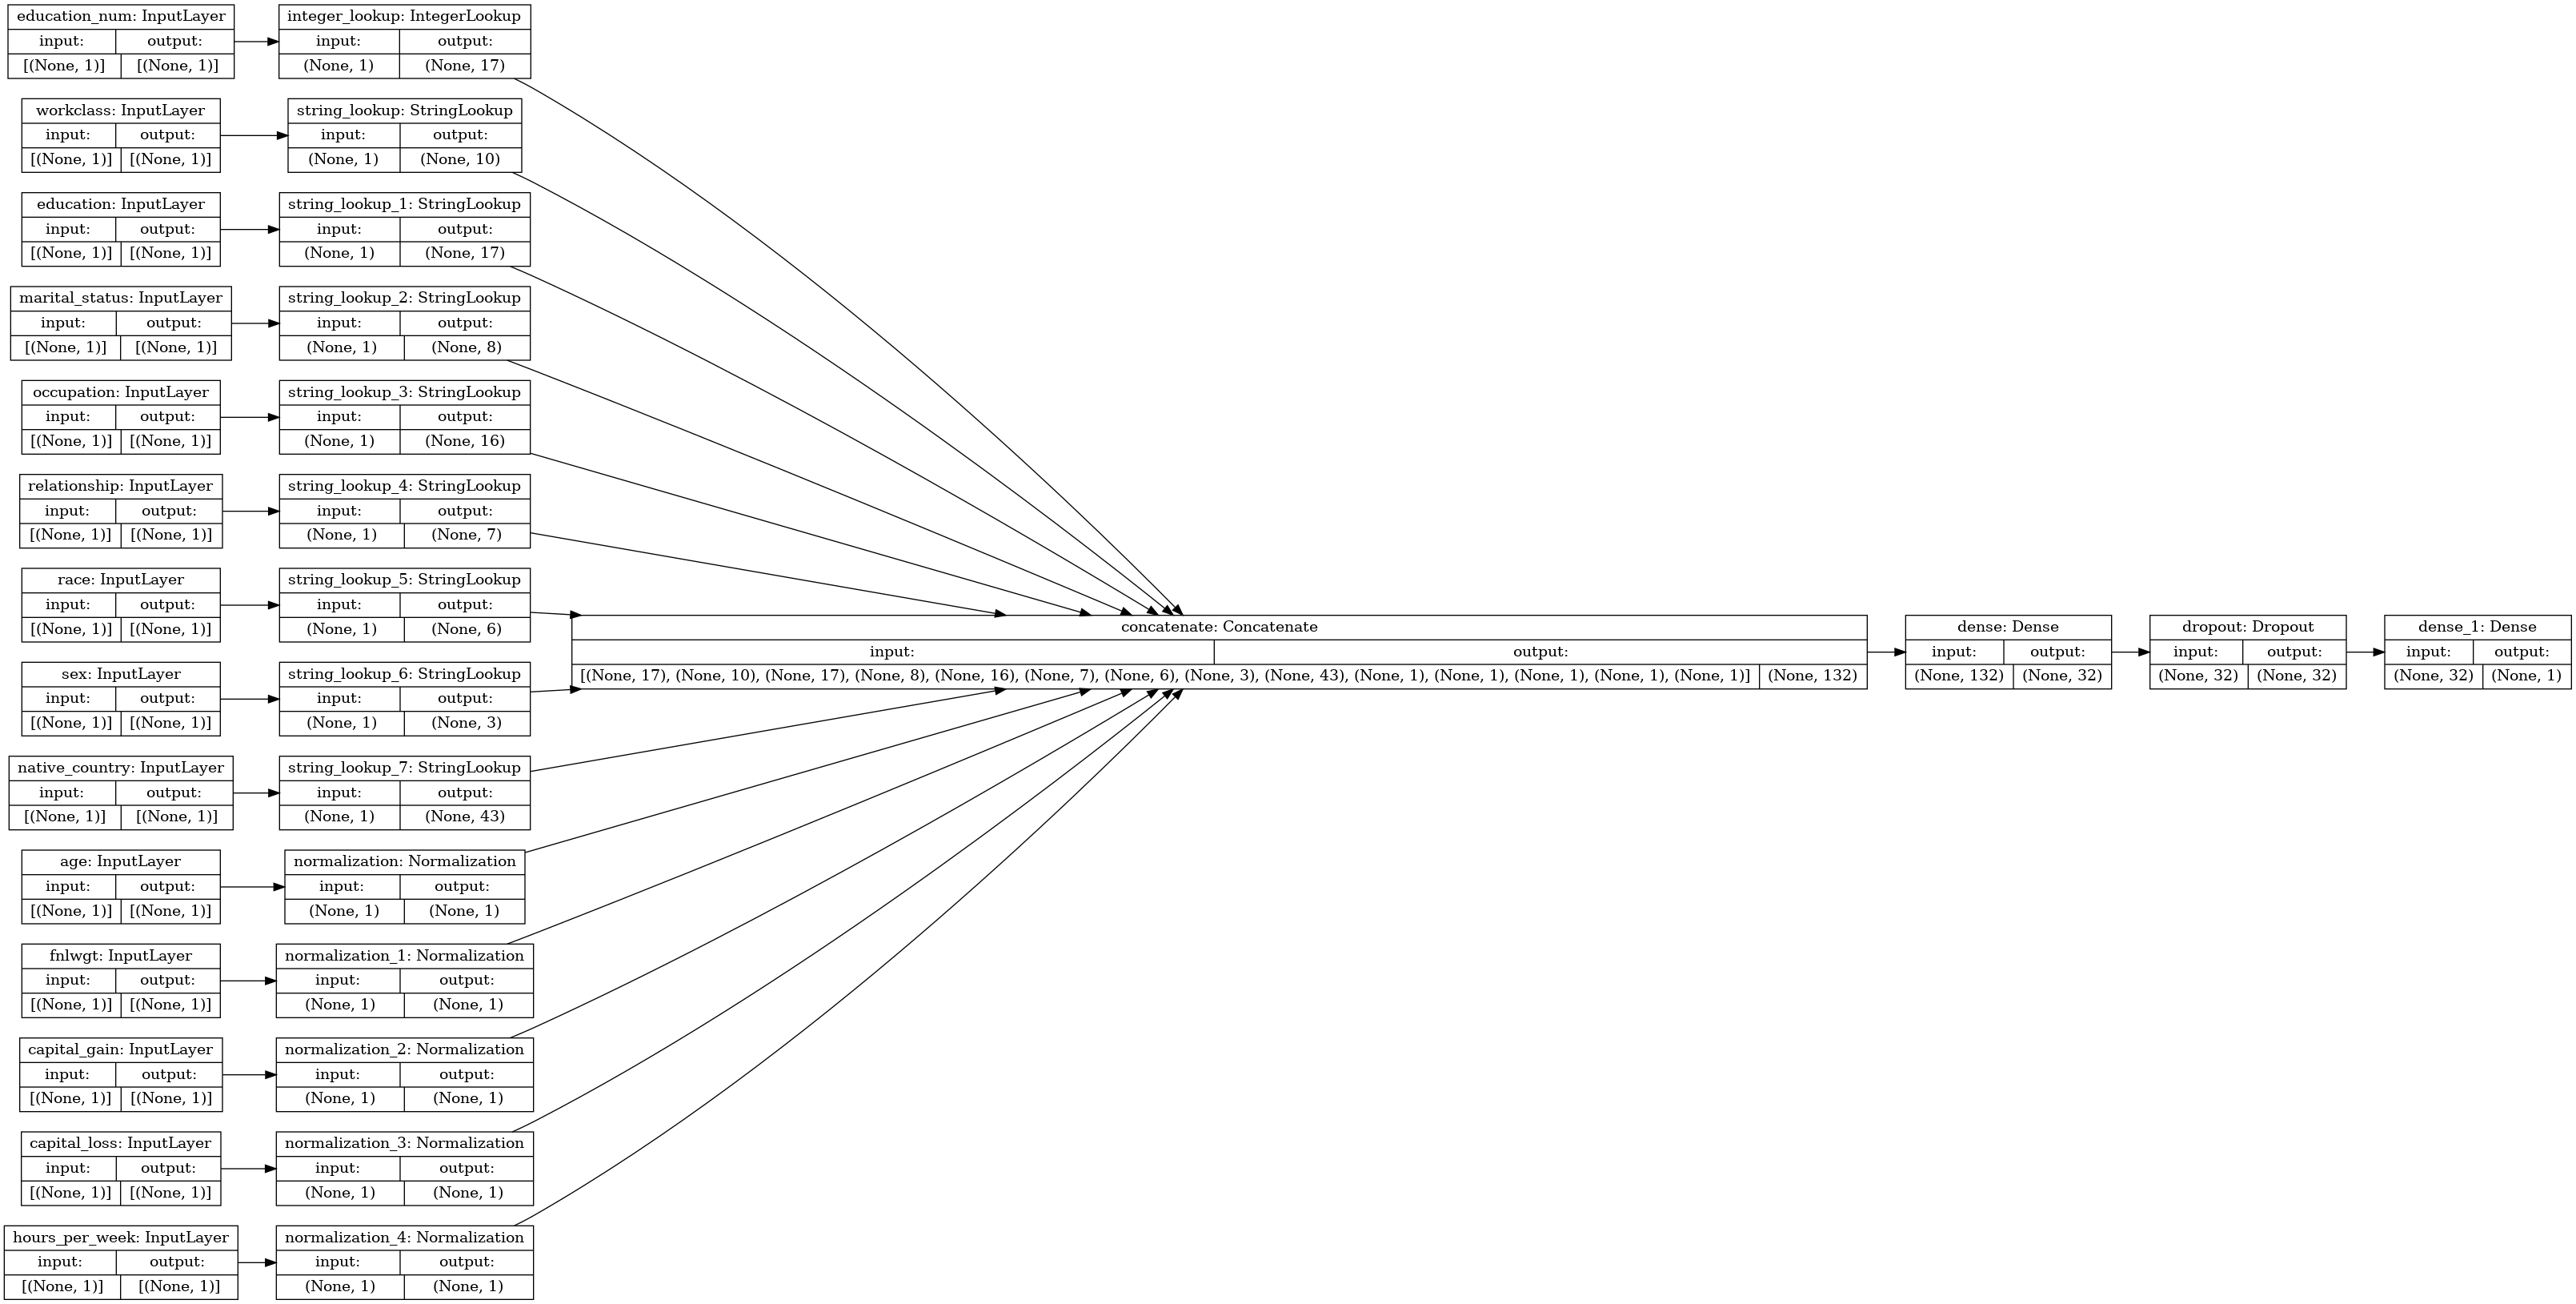

In [13]:
keras.utils.plot_model(model, show_shapes=True, rankdir="LR")

In [14]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
education_num (InputLayer)      [(None, 1)]          0                                            
__________________________________________________________________________________________________
workclass (InputLayer)          [(None, 1)]          0                                            
__________________________________________________________________________________________________
education (InputLayer)          [(None, 1)]          0                                            
__________________________________________________________________________________________________
marital_status (InputLayer)     [(None, 1)]          0                                            
______________________________________________________________________________________________

## Train the model

In [15]:
model.fit(train_ds, epochs=50, validation_data=val_ds)

Epoch 1/50
916/916 [==============================] - 3s 2ms/step - loss: 0.3745 - accuracy: 0.8224 - val_loss: 0.3144 - val_accuracy: 0.8544
Epoch 2/50
916/916 [==============================] - 2s 2ms/step - loss: 0.3301 - accuracy: 0.8498 - val_loss: 0.3090 - val_accuracy: 0.8560
Epoch 3/50
916/916 [==============================] - 2s 2ms/step - loss: 0.3244 - accuracy: 0.8514 - val_loss: 0.3102 - val_accuracy: 0.8547
Epoch 4/50
916/916 [==============================] - 2s 2ms/step - loss: 0.3210 - accuracy: 0.8522 - val_loss: 0.3064 - val_accuracy: 0.8547
Epoch 5/50
916/916 [==============================] - 2s 2ms/step - loss: 0.3200 - accuracy: 0.8518 - val_loss: 0.3045 - val_accuracy: 0.8566
Epoch 6/50
916/916 [==============================] - 2s 2ms/step - loss: 0.3177 - accuracy: 0.8538 - val_loss: 0.3052 - val_accuracy: 0.8578
Epoch 7/50
916/916 [==============================] - 2s 2ms/step - loss: 0.3173 - accuracy: 0.8553 - val_loss: 0.3042 - val_accuracy: 0.8593
Epoch 

## Test set predictions

In [16]:
# Read the test data

test_df = pd.read_csv('adult.test', names=['age','workclass','fnlwgt','education','education_num','marital_status','occupation','relationship','race','sex','capital_gain',
                                            'capital_loss','hours_per_week','native_country','income_level'], sep=', ', engine='python')
print(test_df.shape)
test_df.head()

(16281, 15)


,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income_level
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K.
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K.
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K.
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K.
4,18,?,103497,Some-college,10,Never-married,?,Own-child,White,Female,0,0,30,United-States,<=50K.


In [17]:
# Test data info
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16281 entries, 0 to 16280
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             16281 non-null  int64 
 1   workclass       16281 non-null  object
 2   fnlwgt          16281 non-null  int64 
 3   education       16281 non-null  object
 4   education_num   16281 non-null  int64 
 5   marital_status  16281 non-null  object
 6   occupation      16281 non-null  object
 7   relationship    16281 non-null  object
 8   race            16281 non-null  object
 9   sex             16281 non-null  object
 10  capital_gain    16281 non-null  int64 
 11  capital_loss    16281 non-null  int64 
 12  hours_per_week  16281 non-null  int64 
 13  native_country  16281 non-null  object
 14  income_level    16281 non-null  object
dtypes: int64(6), object(9)
memory usage: 1.9+ MB


In [18]:
# There are some values in the categorical variables where the values are missing indicated by "?",
# those values are replaced with the value "unknown" in the entrie dataset

test_df.replace({"?" : "unknown"}, inplace=True)

In [19]:
# Replace the target variable values as 0 and 1

test_df['income_level'].replace({"<=50K." : 0, ">50K." : 1}, inplace=True)
test_df['income_level'] = test_df['income_level'].astype(np.int64)
test_df.head()

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income_level
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,0
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,0
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,1
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,1
4,18,unknown,103497,Some-college,10,Never-married,unknown,Own-child,White,Female,0,0,30,United-States,0


In [20]:
# Convert test dataframe to test dataset

def tdf_to_tds(df):
    df = df.copy()
    labels = df.pop("income_level")
    ds = tf.data.Dataset.from_tensor_slices((dict(df)))
    # ds = ds.shuffle(buffer_size=len(df))
    return ds, labels

test_ds, test_labels = tdf_to_tds(test_df)
test_ds = test_ds.batch(64)

In [21]:
# Test set predictions

test_predictions = model.predict(test_ds)[:,0]
test_predictions

array([9.5182986e-05, 2.0365688e-01, 4.2751974e-01, ..., 6.8363971e-01,
       3.1371093e-01, 7.6521039e-01], dtype=float32)

In [22]:
# Predictions dataframe

predictions_df = pd.DataFrame({'Predictions': test_predictions, 'Actuals': test_labels})
predictions_df['Predictions'] = np.where(predictions_df['Predictions'] >= 0.5, 1, 0)
predictions_df.head()

,Predictions,Actuals
0,0,0
1,0,0
2,0,1
3,1,1
4,0,0


In [23]:
# Classification report

print(classification_report(predictions_df['Actuals'], predictions_df['Predictions'], labels=[0, 1]))

              precision    recall  f1-score   support

           0       0.89      0.93      0.91     12435
           1       0.74      0.62      0.67      3846

    accuracy                           0.86     16281
   macro avg       0.81      0.78      0.79     16281
weighted avg       0.85      0.86      0.85     16281

